# Projeto 4: MPI
### Filipe F. Borba  
### Insper
### Super Computação, Prof. Igor Montagner


## Introdução

O problema explorado nesse projeto é o algoritmo do Caixeiro Viajante. Este problema encontra-se na área de Otimização discreta, que estuda problemas de otimização baseados em uma sequência de escolhas e que a solução ótima só pode ser encontrada se enumerarmos todas as escolhas possíveis. Em outras palavras, só conseguimos achar a solução ótima se tivermos todas as soluções possíveis. Assim, não existem algoritmos mais eficientes de resolução, pois todos tem complexidade O(2^n) ou pior.

Ao realizar esse teste das sequências de escolhas em paralelo, podemos diminuir consideravelmente o consumo de tempo do programa, o que é bastante interessante para computacão paralela. Contudo, conseguimos potencializar ainda mais essa solução ao utilizar uma GPU que supera a CPU nesses casos, pois possui centenas de threads disponíveis para realizar os cálculos. Mais que isso, se utilizarmos uma série de computadores que conversam entre si via MPI, a performance escala exponencialmente.

O problema do Caixeiro Viajante é o seguinte:

<img src="https://camo.githubusercontent.com/a4d91635c96d345fc31068a4420834d23654f82b/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f7468756d622f312f31312f474c504b5f736f6c7574696f6e5f6f665f615f74726176656c6c696e675f73616c65736d616e5f70726f626c656d2e7376672f35313270782d474c504b5f736f6c7574696f6e5f6f665f615f74726176656c6c696e675f73616c65736d616e5f70726f626c656d2e7376672e706e67" alt="TSP" style="width: 300px;"/>

```Um vendedor possui uma lista de empresas que ele deverá visitar em um certo dia. Não existe uma ordem fixa: desde que todos sejam visitados seu objetivo do dia está cumprido. Interessado em passar o maior tempo possível nos clientes ele precisa encontrar a sequência de visitas que resulta no menor caminho.```

Para nosso projeto em específico, temos algumas simplificações:
- o nosso caixeiro usa Waze e já sabe qual é o caminho com a menor distância entre dois pontos;
- ele começa seu trajeto na empresa 0. Ou seja, basta ele encontrar um trajeto que passe por todas as outras e volte a empresa ```0```;
- ele não pode passar duas vezes na mesma empresa. Ou seja, a saída é uma permutação de ```0 ... (N-1)```



Finalmente, os objetivos deste projeto são

1. implementar uma versão ingênua do 2-opt utilizando MPI.
2. implementar a enumeração exaustiva utilizando MPI.

De maneira mais avançada, também temos:
3. implementar a enumeração exaustiva com branch and bound utilizando MPI.
4. implementar a enumeração exaustiva com branch and bound utilizando MPI e GPU.

** Como descrito em https://github.com/Insper/supercomp/blob/master/projeto-02/enunciado.md

## Organização do Projeto

O projeto foi realizado utilizando a linguagem C++ e o Boost MPI, juntamente com 3 máquinas t3.micro da AWS. Temos, então, alguns arquivos diferentes.

* Arquivo 2opt_sol.cpp, que gera 10.000 soluções aleatórias, mas as otimiza utilizando a busca local 2-opt.
* Arquivo mpi-sol.cpp, que realiza a enumeração exaustiva.

Além disso, o projeto possui um CMakeLists.txt que possibilita a compilação dos executáveis. São eles:
* 2opt-spl (solução aleatória com otimização 2-opt)
* time-2opt_sol (com print de tempo - solução aleatória com otimização 2-opt)
* mpi-sol (solução de enumeração exaustiva)
* time-mpi-sol (com print de tempo - solução de enumeração exaustiva)

OBS: os outros executáveis foram criados para que a saída devolvesse o tempo, mas o código neles é igual.

Para compilar todos os executáveis, basta usar os seguintes comandos na pasta raíz do projeto:

```mkdir build; cd build; cmake ..; make ```

O comando ```make``` é responsável por compilar os executáveis.
Após isso, para iniciar cada executável, basta utilizar o comando 

```mpiexec -n 3 ./nome_do_arquivo < ../tests/nome_da_entrada```

dentro da pasta ```build```.

# Resultados

## Comparação com Sequencial sem MPI

O projeto em MPI possui poucas diferenças em relação ao projeto sequencial local. Podemos comparar com uma lista de prós em contras.

Projeto MPI:  
  
Vantagens:
- Ganho muito claro de desempenho por distribuir as tarefas entre várias máquinas.
- A complexidade de implementar o código em MPI sem passar mensagens não é tão grande.
- Escalabilidade imediata. (+ máquinas = + processamento!)

Desvantagens:
- Um código mais complexo (ex: branch and bound) pode ficar bem mais difícil de ser implementado.

Podemos então concluir que a implementação em MPI é bastante interessante, pois temos a solução ótima nesses casos. Contudo, ao adicionar mais complexidade ao código (bb ou CUDA), pode ficar ainda mais difícil de implementar.

Vejamos como isso se comporta na prática:

In [5]:
%matplotlib inline
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

In [6]:
# Pegar o nome dos arquivos de saída
output = sorted([n for n in os.listdir("./output/")])
output

['time-mpi-sol-in10']

In [11]:
def print_file(file):
    with open("./output/" + file, 'r') as fin:
        print(f"-------{file}-------")
        print(fin.read())

In [12]:
print_file(output[0])

-------time-mpi-sol-in10-------
10
milisegundo(s).
6303.41552 1
0 9 5 2 1 7 8 3 4 6 



In [35]:
def parse_output_file(file):
    with open("./output/" + file, 'r') as fin:
        output = fin.read().splitlines()
        print(file.split("-"))
        input_file = file.split("-")[-1]
        executable = file.replace(f"-{input_file}", "")
        time = output[0]
        ms = output[1]
        best_cost = output[2][:-2]
        solution = output[3]
        return [executable, input_file, time, ms, best_cost, solution]

In [36]:
parse_output_file(output[0])

['time', 'mpi', 'sol', 'in10']


['time-mpi-sol',
 'in10',
 '10',
 'milisegundo(s).',
 '6303.41552',
 '0 9 5 2 1 7 8 3 4 6 ']

Como pode-se observar com as saídas dos testes, o caminho encontrado pelo branch and bound é o ótimo e ele é retornado quase que imediatamente. Apesar do 2opt-sol demorar um pouquinho mais, ele também encontra o caminho ótimo, com o random-sol logo atrás, com um custo aceitável. Essa aproximação se dá pelo fato de testarmos muitas soluções (no caso, 10.000), o que permite uma aproximação melhor da solução ótima. Quanto maior o número de tentativas, mais provável do resultado ser o caminho ótimo. Nesse caso, pelo menos uma de nossas soluções otimizadas com o 2opt foi capaz de encontrar o melhor caminho possível, o que vai ser mais difícil de acontecer para caminhos maiores.

##  Testes de Desempenho

Aqui estamos preocupados com a diferença de desempenho, então o tamanho das entradas é maior. O tempo foi medido a partir da biblioteca <cuda_runtime.h> e o nvprof do próprio CUDA. Testaremos então o tempo de uma execução e a saída para as duas soluções em GPU (aleatório e 2-opt). Para isso, existem alguns testes do TSPLIB já resolvidos que serão utilizados como base aqui. São eles:
- in10.txt (N = 10) // Pequeno
- burma14.txt (N = 14)   // Médio
- ulysses16.txt (N = 16)  // Grande
- ulysses22.txt (N = 22)   // Muito Grande

Esses testes foram escolhidos pois já representam uma grande diferença de desempenho entre os executáveis. O pr439 serve mais para verificar os limites da máquina em termos de memória e processamentos.

In [19]:
data = []
for i in inputs:
    for f in files[:-1]:
        data.append(run_nvprof_test(f, i))

--2opt-sol------berlin52.txt--
543.97ms opt_sol
3.9350us [CUDA memcpy HtoD]
113.15us [CUDA memcpy DtoH]
133.92ms cudaMalloc
--random-sol------berlin52.txt--
3.0383ms random_sol
3.9030us [CUDA memcpy HtoD]
115.78us [CUDA memcpy DtoH]
128.45ms cudaMalloc
--2opt-sol------ch130.txt--
8.72489s opt_sol
4.1920us [CUDA memcpy HtoD]
277.69us [CUDA memcpy DtoH]
125.39ms cudaMalloc
--random-sol------ch130.txt--
5.3729ms random_sol
4.1600us [CUDA memcpy HtoD]
278.52us [CUDA memcpy DtoH]
123.71ms cudaMalloc
--2opt-sol------gil262.txt--
75.0976s opt_sol
4.5440us [CUDA memcpy HtoD]
553.88us [CUDA memcpy DtoH]
124.41ms cudaMalloc
--random-sol------gil262.txt--
14.233ms random_sol
4.5120us [CUDA memcpy HtoD]
551.51us [CUDA memcpy DtoH]
132.29ms cudaMalloc
--2opt-sol------pr439.txt--
380.971s opt_sol
5.2480us [CUDA memcpy HtoD]
925.15us [CUDA memcpy DtoH]
123.67ms cudaMalloc
--random-sol------pr439.txt--
26.411ms random_sol
5.0240us [CUDA memcpy HtoD]
924.30us [CUDA memcpy DtoH]
133.09ms cudaMalloc


In [20]:
df = pd.DataFrame(data, dtype=np.float64, columns=["Executavel", "Entrada", "Tempo Kernel", "Nome Kernel",
                                                  "Tempo HtoD", "Nome HtoD", "Tempo DtoH", "Nome DtoH",
                                                  "Tempo Malloc", "Nome Malloc"])
df

# Todos os tempos estão em milissegundos!
# Coluna 0: Executável
# Coluna 1: Entrada
# Coluna 2: Tempo de execução Kernel
# Coluna 3: Nome kernel
# Coluna 4: Tempo de execução Memcpy
# Coluna 5: Nome memcpy HtoD
# Coluna 6: Tempo de execução Memcpy
# Coluna 7: Nome memcpy DtoH
# Coluna 8: Tempo de execução Malloc

,Executavel,Entrada,Tempo Kernel,Nome Kernel,Tempo HtoD,Nome HtoD,Tempo DtoH,Nome DtoH,Tempo Malloc,Nome Malloc
0,2opt-sol,berlin52.txt,543.9700,opt_sol,0.003935,[CUDA memcpy HtoD],0.11315,[CUDA memcpy DtoH],133.92,cudaMalloc
1,random-sol,berlin52.txt,3.0383,random_sol,0.003903,[CUDA memcpy HtoD],0.11578,[CUDA memcpy DtoH],128.45,cudaMalloc
2,2opt-sol,ch130.txt,8724.8900,opt_sol,0.004192,[CUDA memcpy HtoD],0.27769,[CUDA memcpy DtoH],125.39,cudaMalloc
3,random-sol,ch130.txt,5.3729,random_sol,0.004160,[CUDA memcpy HtoD],0.27852,[CUDA memcpy DtoH],123.71,cudaMalloc
4,2opt-sol,gil262.txt,75097.6000,opt_sol,0.004544,[CUDA memcpy HtoD],0.55388,[CUDA memcpy DtoH],124.41,cudaMalloc
5,random-sol,gil262.txt,14.2330,random_sol,0.004512,[CUDA memcpy HtoD],0.55151,[CUDA memcpy DtoH],132.29,cudaMalloc
6,2opt-sol,pr439.txt,380971.0000,opt_sol,0.005248,[CUDA memcpy HtoD],0.92515,[CUDA memcpy DtoH],123.67,cudaMalloc
7,random-sol,pr439.txt,26.4110,random_sol,0.005024,[CUDA memcpy HtoD],0.92430,[CUDA memcpy DtoH],133.09,cudaMalloc


Verificando o dataframe, podemos verificar que o tempo de alocação de memória e cópia acaba sendo quase insignificante perto do tempo de processamento do kernel das funções. Esse efeito acaba crescendo muito quanto maior as entradas: o tempo de "preparação" é mínimo e de processamento é máximo. Além disso, ele não acaba mudando muito de acordo com o tamanho da entrada.

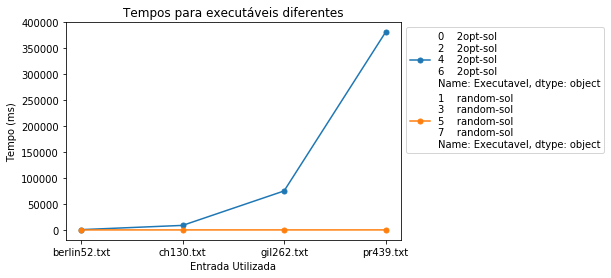

In [24]:
groups = df.groupby("Executavel")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["Entrada"], group["Tempo Kernel"], marker='o', linestyle='-', ms=5, label=group["Executavel"])
plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('Entrada Utilizada')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Como podemos verificar nos gráficos acima, o algoritmo 2opt-sol acaba sendo MUITO mais lento que o random_sol. Isso acontece porque o 2opt realiza 2 fors que permutam a solução aleatória com o objetivo de encontrar um custo melhor. Além disso, para cada permutação, ele recalcula o custo total, sendo, novamente, bem ineficiente em termos de operações. Contudo, como pudemos verificar nos testes básicos, o 2opt acaba encontrando caminhos com custo bem menores, o que acaba sendo muito interessante, visto que sua implementação está totalmente ingênua. Portanto, o 2opt-sol sempre vai encontrar uma solução melhor que o random-sol.

Para melhorar o programa, seria necessário otimizar a memória e balancear melhor as cargas das threads. Ainda, seria interessante a utilização do Branch and Bound nesse caso, mas a implementação não é tão trivial. 